In [86]:
import geopandas as gpd
import xarray as xr
import rioxarray 
from shapely.geometry import box
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

from geocube.api.core import make_geocube



root = Path.cwd()


class CatskillSite():
    def __init__(self,site_name,sentinel_data,polygons):
        self.site_name = site_name
        self.sentinel_data = sentinel_data.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
        self.polygons = polygons.reset_index().to_crs(26918)
        self.bbox = self.get_bbox()

        self.site_polygons = self.get_site_polygons()

        self.beech_idx = self.site_polygons.loc[self.site_polygons.Name!='non-beech stand']['index'].astype('float').values
        self.nonbeech_idx = self.site_polygons.loc[self.site_polygons.Name=='non-beech stand']['index'].astype('float').values

        self.raster_polys = self.rasterize_polys()

    def get_bbox(self):
        b = self.sentinel_data.rio.bounds()
        return box(*b)
    
    def get_site_polygons(self):
        df = gpd.GeoDataFrame({"id":1,"geometry":[self.bbox]})
        idx = df.sindex.query(self.polygons.geometry, predicate="intersects")[0]
        return self.polygons.iloc[idx]
    
    # rasterize polygons
    def rasterize_polys(self):
        g = make_geocube(
        vector_data=self.site_polygons,
        measurements=["index"],
        like=self.sentinel_data, # ensure the data are on the same grid
    )
        return g
    
    # plot rasterized polygons overlaid with vector polygons
    def plot_rasterized_polys(self):
        fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

        p = self.raster_polys.index.plot.imshow(ax=ax)
        self.site_polygons.plot(ax=ax,alpha=.7)
        p.colorbar.remove()
        plt.title(f'Rasterized Polygons: {self.site_name.title()} Site')
        plt.tight_layout()
        plt.show()

    # store pixel values for each plot in dataframe
    def make_pixel_df(self,idx='beech'):
        
        if idx == 'beech':
            id = self.beech_idx
        else:
            id = self.nonbeech_idx

        if len(id) == 1:
            pixels = self.sentinel_data.where(self.raster_polys.index==id).assign_coords({'time':[str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values]})
        else:
            pixels = self.sentinel_data.where((self.raster_polys.index==id[0])|(self.raster_polys.index==id[1]))

        stacked = pixels.stack(spatial=('x','y'))
        transposed = stacked.transpose('spatial', 'band', 'time')
        # convert to dataframe
        df = transposed.to_dataframe(name='value').unstack(['band', 'time'])

        df = df.loc[:,('value')]

        df.columns = df.columns.set_levels([str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values],level='time')
        df = df.reset_index()

        df.columns = [f'{x[0]}_{x[1]}' for x in df.columns]

        df.rename(columns={df.columns[0]:'x',df.columns[1]:'y'},inplace=True)

        df = df.drop(['x','y'],axis=1)

        df = df[df.isna().sum(axis=1) == 0]
        print(df.shape)

        return df
   
    # store mean values for each plot in dataframe
    def make_site_means_df(self, i='beech'):

        out_grid = self.raster_polys
    
        out_grid['sentinel'] = (self.sentinel_data.dims, self.sentinel_data.values, self.sentinel_data.attrs, self.sentinel_data.encoding)

        # calculate means for each group (polygon)
        grouped_sentinel = out_grid.drop_vars("spatial_ref").groupby(out_grid.index)
        grid_mean = grouped_sentinel.mean().rename({"sentinel": "sentinel_mean"})

        zonal_stats = grid_mean.to_dataframe()

        # put beech/nonbeech into seperate dataframes 
        if i == 'beech':
            idx = self.beech_idx
        else:
            idx = self.nonbeech_idx
        
        df = zonal_stats.loc[idx]
        
        df_unstack = df.unstack(level='band').droplevel('band',axis=1)
        df_unstack.columns = self.sentinel_data.band.values

        if len(np.unique(df_unstack.index.get_level_values(level='index'))) < 2: # check if multiple polygons
            df_unstack = df_unstack.reset_index()
            df_unstack['time'] = [str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values]
            return df_unstack
        
        else:   # if multiple polygons, return a list of dataframes
            df_list = []
            for i in range(0,len(idx)):
                df1 = df_unstack.loc[idx[i]]
                df1 = df1.reset_index()
                df1['time'] = [str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values]
                df_list.append(df1)
            
            return df_list


In [82]:

class NeonSite():
    def __init__(self,root,site_name,geometry,epsg):
        self.site_name = site_name
        self.epsg = epsg
        self.base_dir = root

        b = xr.open_dataarray(self.base_dir / 'sentinel_data' / f'2019_{self.site_name}.nc')
        self.sentinel = b.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
        self.geometry = geometry
        self.pixel_df = pd.DataFrame()

    def get_pixel_df(self):

        col_names = []
        for i in self.sentinel.band.values:
            for j in self.sentinel.time.values:
                col_names.append(f'{i}_{j}')

        q = self.geometry.reset_index()
        cc = q.get_coordinates().reset_index().drop('index',axis=1)

        pixel_df = pd.DataFrame()

        for i,row in q.iterrows():
            value = self.sentinel.sel(x=cc.iloc[i,0], y=cc.iloc[i,1], method="nearest").values
            df = pd.DataFrame(data=np.reshape(value,(1,260)),columns=col_names)
            df['taxonID'] = q.loc[i,'taxonID']
            pixel_df = pd.concat([pixel_df,df])

            self.pixel_df = pixel_df
        
        return pixel_df
    
    def save_pixel_df(self,filename):

        p = self.pixel_df.columns.str.split('T')# change col names and write to disk
        cols = [x[0] for x in p]

        self.pixel_df.columns = cols

        self.pixel_df.to_csv(root / 'output' / f'{self.site_name.upper()}' / f'{filename}.csv')






### Bartlett

In [16]:
q = pd.concat([gpd.read_file(f) for f in os.scandir(root/'temp') if f.path.endswith('.gpkg')])

In [83]:
bart = NeonSite(root,site_name='bart',geometry=q,epsg=26919)

In [84]:
t = bart.get_pixel_df()
bart.save_pixel_df('sentinel_pixels')

### Catskills

In [2]:
# read in data
polys = gpd.read_file(root / 'beech_stands' / 'Beech Stand Polygons.kml')

SITE = 'pecoy'
pecoy_sentinel = xr.open_dataarray(root / 'sentinel_data' / f'2023_{SITE}.nc')

SITE = 'roundtop'
roundtop_sentinel = xr.open_dataarray(root / 'sentinel_data' / f'2023_{SITE}.nc')

SITE = 'visitors'
visitors_sentinel = xr.open_dataarray(root / 'sentinel_data' / f'2023_{SITE}.nc')

In [ ]:
pecoy = CatskillSite('Pecoy',pecoy_sentinel, polys)
roundtop = CatskillSite('Roundtop',roundtop_sentinel,polys)
visitors = CatskillSite('Visitors',visitors_sentinel,polys)

beech_pixels = pd.concat([pecoy.make_pixel_df('beech'),roundtop.make_pixel_df('beech'),visitors.make_pixel_df('beech')])
nonbeech_pixels = pd.concat([pecoy.make_pixel_df('nonbeech'),roundtop.make_pixel_df('nonbeech'),visitors.make_pixel_df('nonbeech')])

beech_pixels.to_csv(root / 'output' / 'beech_sentinel_pixels.csv')
nonbeech_pixels.to_csv(root / 'output' / 'nonbeech_sentinel_pixels.csv')

### Plot Density Curves

In [94]:
# filter columns
jan_cols = [x for x in b1.columns if '-01-' in x]
feb_cols = [x for x in b1.columns if '-02-' in x]
mar_cols = [x for x in b1.columns if '-03-' in x]
apr_cols = [x for x in b1.columns if '-04-' in x]
may_cols = [x for x in b1.columns if '-05-' in x]
jun_cols = [x for x in b1.columns if '-06-' in x]
jul_cols = [x for x in b1.columns if '-07-' in x]
aug_cols = [x for x in b1.columns if '-08-' in x]
sept_cols = [x for x in b1.columns if '-09-' in x]
oct_cols = [x for x in b1.columns if '-10-' in x]
nov_cols = [x for x in b1.columns if '-11-' in x]
dec_cols = [x for x in b1.columns if '-12-' in x]


In [91]:
site_name = 'bart'

b = pd.read_csv(root / 'output' / site_name.upper() / 'sentinel_pixels.csv')

b1 = b.loc[b['taxonID']=='FAGR']
b2 = b.loc[b['taxonID']!='FAGR']

In [177]:
b1 = pd.read_csv(root / 'output' / 'beech_sentinel_pixels.csv')
b2 = pd.read_csv(root / 'output' / 'nonbeech_sentinel_pixels.csv')


In [95]:
def plot_spec_sigs(b1,b2,filter_cols):

    b1 = b1[filter_cols].mean()
    b2= b2[filter_cols].mean()

    cols = [x.split('_')[0] for x in filter_cols]

    fig, ax = plt.subplots(figsize=(10,5))

    b1.plot(ax=ax,legend=True)
    b2.plot(ax=ax,legend=True)
    ax.set_xlabel('Spectral Band')
    ax.set_ylabel('Reflectance')
    ax.set_xticks(range(0,10,1))
    ax.set_xticklabels(cols)
    ax.legend(labels=['beech','nonbeech'])
    plt.title(filter_cols[0].split('_')[1])


def plot_density(b1,b2,day,i,axes):
    b1 = b1[day]
    b2 = b2[day]

    b1_r = b1.iloc[:,2]
    b2_r = b2.iloc[:,2]
 
    b = pd.concat([b1_r,b2_r],axis=1)
    b.columns = ['beech','nonbeech']

    sns.kdeplot(data=b,ax=axes[i])
    axes[i].set_title(f'Red {day[0].split('_')[1]}')

    b1_s = b1.iloc[:,9]
    b2_s = b2.iloc[:,9]

    b = pd.concat([b1_s,b2_s],axis=1)
    b.columns = ['beech','nonbeech']

    sns.kdeplot(data=b,ax=axes[i+1])
    axes[i+1].set_title(f'Shortwave 2 {day[0].split('_')[1]}')
    
def get_mean_months(df,col_list,band):
    df = df[col_list]
    mean = df[[x for x in df.columns if band in x]].mean(axis=1)
    return mean

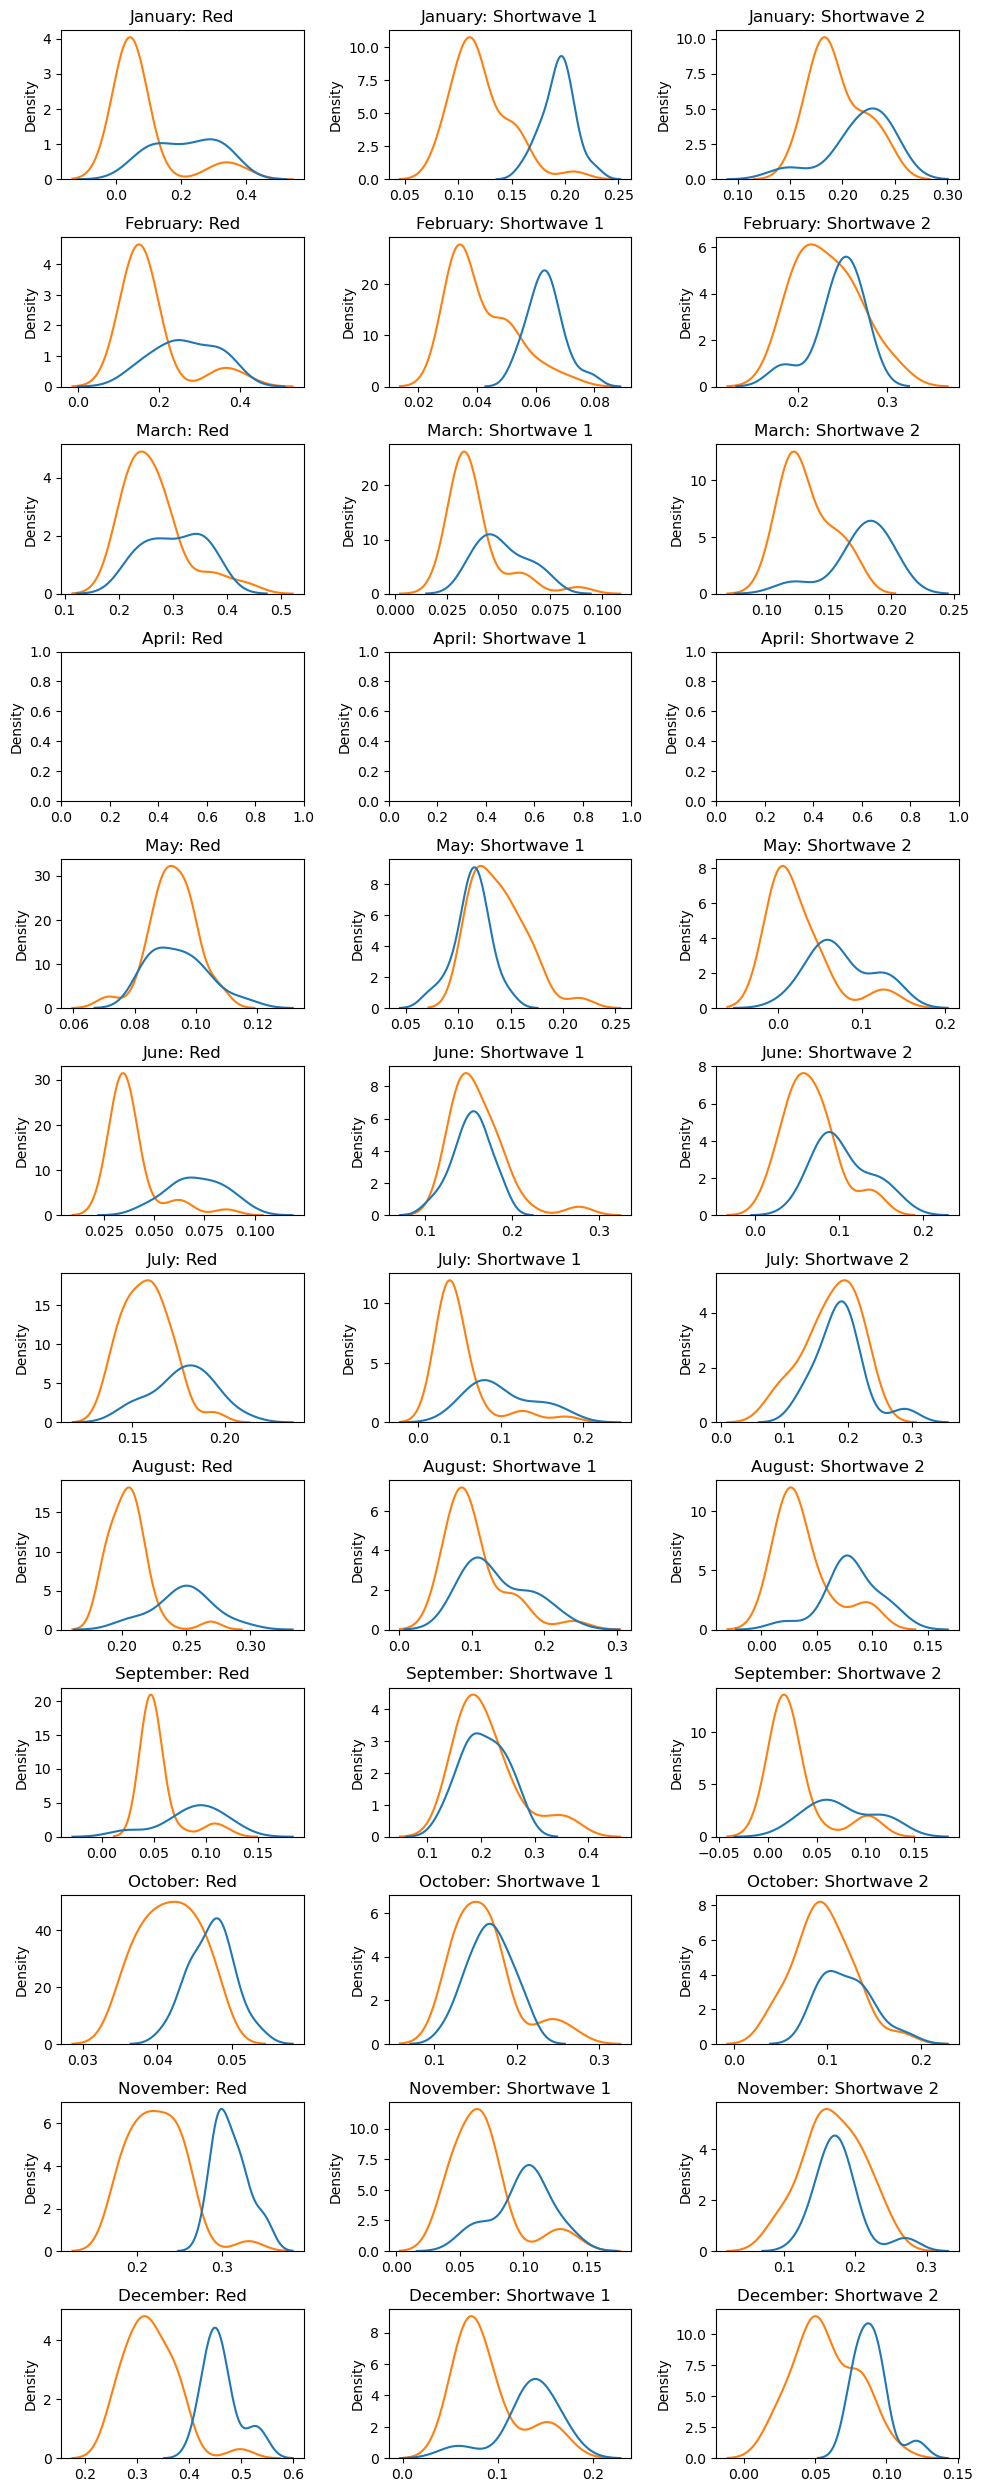

In [96]:

cols = [jan_cols,feb_cols,mar_cols,apr_cols,may_cols,jun_cols,jul_cols,aug_cols,sept_cols,oct_cols,nov_cols,dec_cols]
month_names = ['January','February','March','April','May','June','July','August', 'September', 'October','November','December']

fig, axes = plt.subplots(nrows=12,ncols=3,figsize=(10,25))

axes = axes.ravel()

i=0
n=0
for col in cols:
    b1_m = get_mean_months(b1,col,'B04')
    b2_m = get_mean_months(b2,col,'B04')
    df_m = pd.DataFrame({'beech':b1_m,'nonbeech':b2_m})
    sns.kdeplot(data=df_m,ax=axes[i],legend=False)
    axes[i].set_title(f'{month_names[n]}: Red')

    b1_m = get_mean_months(b1,col,'B11')
    b2_m = get_mean_months(b2,col,'B11')
    df_m = pd.DataFrame({'beech':b1_m,'nonbeech':b2_m})
    sns.kdeplot(data=df_m,ax=axes[i+1],legend=False)
    axes[i+1].set_title(f'{month_names[n]}: Shortwave 1')

    b1_m = get_mean_months(b1,col,'B12')
    b2_m = get_mean_months(b2,col,'B12')
    df_m = pd.DataFrame({'beech':b1_m,'nonbeech':b2_m})
    sns.kdeplot(data=df_m,ax=axes[i+2],legend=False)
    axes[i+2].set_title(f'{month_names[n]}: Shortwave 2')


    i+=3
    n+=1
plt.tight_layout(pad=1)

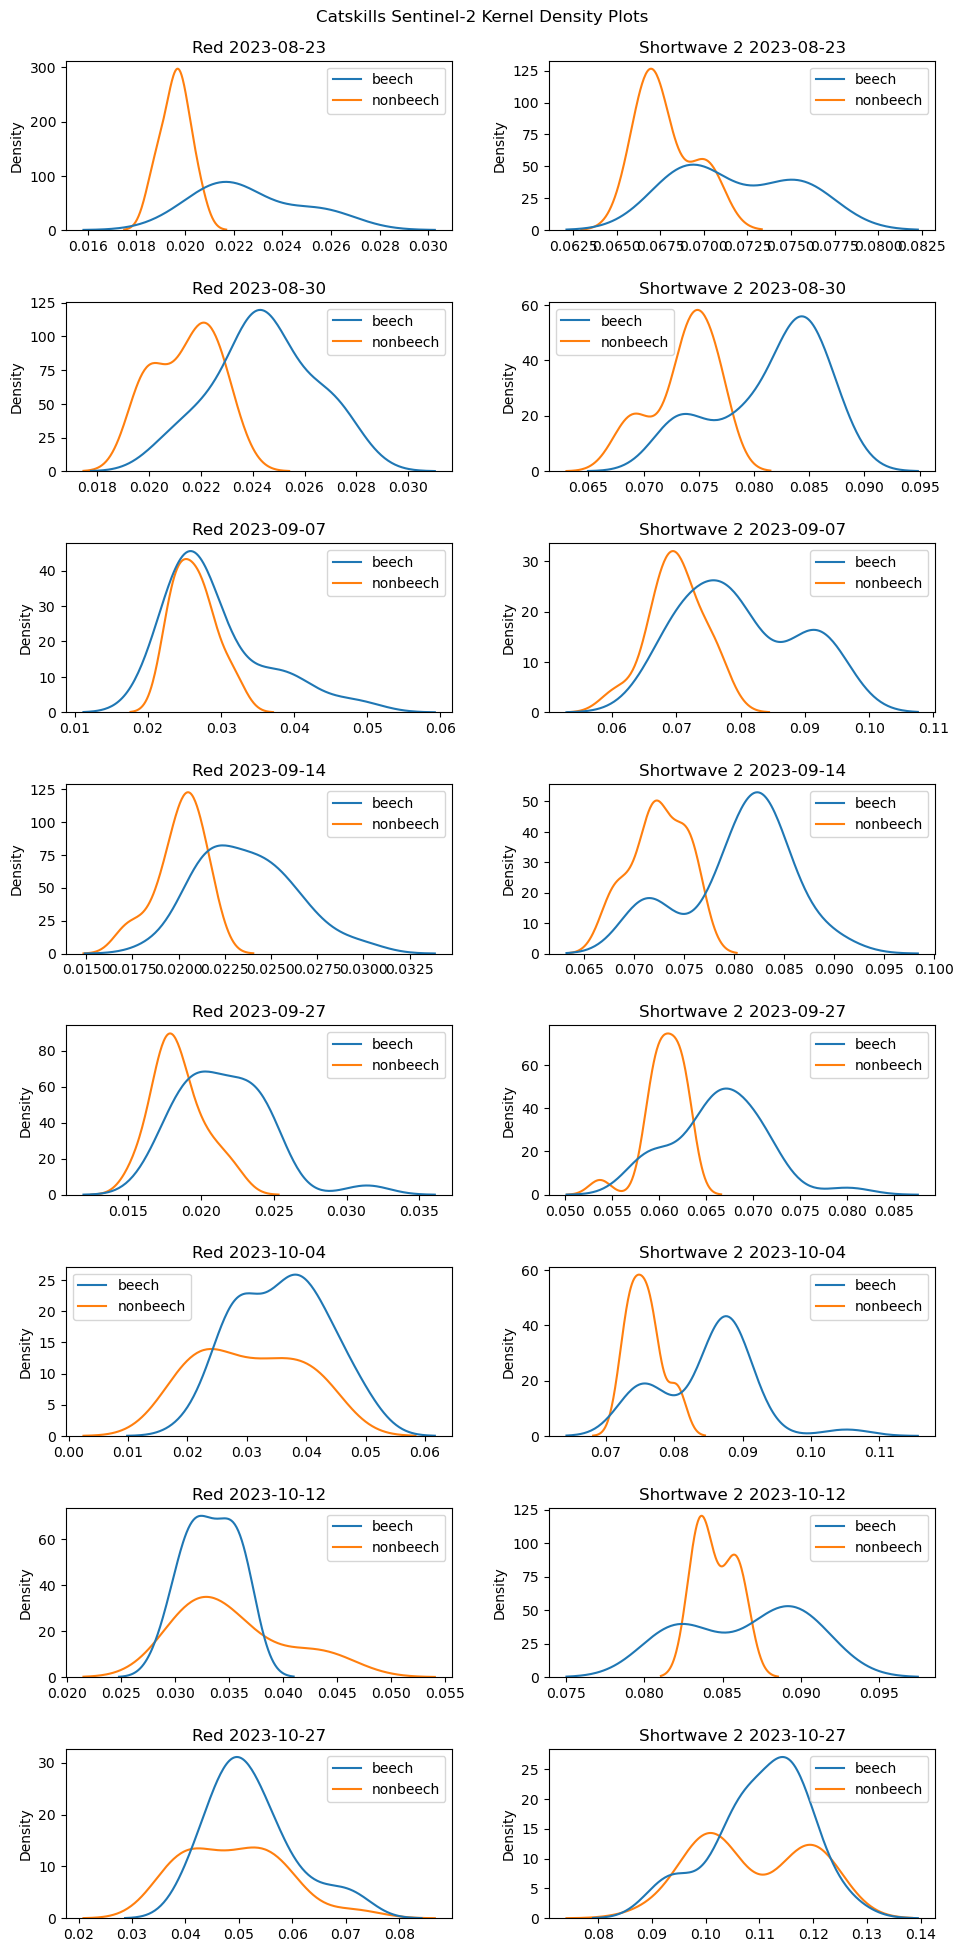

In [157]:
days = [aug_23_cols,aug_30_cols,sept_7_cols,sept_14_cols,sept_27_cols,oct_4_cols,oct_12_cols,oct_27_cols]

fig, axes = plt.subplots(ncols=2,nrows=len(days),figsize=(10,20))
plt.suptitle('Catskills Sentinel-2 Kernel Density Plots')
axes.ravel()
i = 0
for n,day in enumerate(days):
    plot_density(b1,b2,day,i=i,axes=axes.ravel())
    i+=2

fig.tight_layout(pad=2)
    

### Calculate new indices

In [3]:
pecoy_sentinel

<xarray.DataArray 'stackstac-a612b623bead114048bf3ea0d9edfde8' (time: 29,
                                                                band: 10,
                                                                y: 21, x: 21)> Size: 1MB
[127890 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 232B 2023-01-15T15:56:11.024000 ... 2023-1...
  * x        (x) float64 168B 5.722e+05 5.722e+05 ... 5.724e+05 5.724e+05
  * y        (y) float64 168B 4.667e+06 4.667e+06 ... 4.666e+06 4.666e+06
  * band     (band) object 80B 'B02' 'B03' 'B04' 'B05' ... 'B8A' 'B11' 'B12'

### Get mean values for plots

In [7]:
# add satellite data to dataset
out_grid['sentinel'] = (sentinel.dims, sentinel.values, sentinel.attrs, sentinel.encoding)

# calculate means for each group (polygon)
grouped_sentinel = out_grid.drop_vars("spatial_ref").groupby(out_grid.index)
grid_mean = grouped_sentinel.mean().rename({"sentinel": "sentinel_mean"})

c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension index because variable index is not a coordinate. To create an index for index, please first call `.set_coords('index')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [8]:
zonal_stats = grid_mean.to_dataframe()

# put beech/nonbeech into seperate dataframes 
beech_means = zonal_stats.loc[beech_idx]
nonbeech_means = zonal_stats.loc[nonbeech_idx]

In [ ]:
def make_site_means_dfs(self, i='beech'):

    out_grid = self.raster_polys
   
    out_grid['sentinel'] = (self.sentinel_data.dims, self.sentinel_data.values, self.sentinel_data.attrs, self.sentinel_data.encoding)

    # calculate means for each group (polygon)
    grouped_sentinel = out_grid.drop_vars("spatial_ref").groupby(out_grid.index)
    grid_mean = grouped_sentinel.mean().rename({"sentinel": "sentinel_mean"})

    zonal_stats = grid_mean.to_dataframe()

    # put beech/nonbeech into seperate dataframes 
    if i == 'beech':
        df = zonal_stats.loc[self.beech_idx]
    else:
        df = zonal_stats.loc[self.nonbeech_idx]
    
    df_unstack = df.unstack(level='band').droplevel('band',axis=1)
    df_unstack.columns = self.sentinel_data.band.values

    if len(np.unique(df_unstack.index.get_level_values(level='index'))) < 2: # check if multiple polygons
        df_unstack = df_unstack.reset_index()
        df_unstack['time'] = [str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values]
        return df_unstack
    
    else:   # if multiple polygons, return a list of dataframes
        df_list = []
        for i in range(0,len(idx)):
            df1 = df_unstack.loc[idx[i]]
            df1 = df1.reset_index()
            df1['time'] = [str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values]
            df_list.append(df1)
        
        return df_list

In [9]:
def unstack_and_relabel_dfs(df,idx=None):
    """Reformat and tidy dataframes produced by calling to_dataframe() on zonal stats array"""

    df_unstack = df.unstack(level='band').droplevel('band',axis=1)
    df_unstack.columns = sentinel.band.values

    if len(np.unique(df_unstack.index.get_level_values(level='index'))) < 2: # check if multiple polygons
        df_unstack = df_unstack.reset_index()
        df_unstack['time'] = [str(x.astype('datetime64[D]')) for x in sentinel.time.values]
        return df_unstack
    
    else:   # if multiple polygons, return a list of dataframes
        df_list = []
        for i in range(0,len(idx)):
            df1 = df_unstack.loc[idx[i]]
            df1 = df1.reset_index()
            df1['time'] = [str(x.astype('datetime64[D]')) for x in sentinel.time.values]
            df_list.append(df1)
        
        return df_list
        

        

In [10]:
# reformat and label dataframes
beech_means = unstack_and_relabel_dfs(beech_means)
nonbeech_means = unstack_and_relabel_dfs(nonbeech_means)

In [11]:
# save to disk
beech_means.to_csv(root / 'output' / f'{SITE}_beech_polygon_means.csv')
nonbeech_means.to_csv(root / 'output' / f'{SITE}_nonbeech_polygon_means.csv')